## setup

In [2]:
import json
from keppel.utils import compact_json

e={'label_type': 'title', 'txt': 'I ct\nntroductIon to of\nthe horax hest', 'fonts': [[['FUCJOE+JansonText-Roman-SC800', 27.0], 7], [['FUCJOE+JansonText-Roman-SC800', 21.5], 27]], 'id': 0, 'pgs': [7, 7], 'labels': [0, 0], 'bbox_raw': (314, 182, 994, 301), 'bbox_pad': (149.29073529411764, 86.37034947984395, 478.2607352941177, 145.3942799089727)}
with open('o.json', "w", encoding="utf8") as f:
    entries_dict = [e]
    s = json.dumps(entries_dict, indent=2, ensure_ascii=False)
    s = compact_json(s)
    print(s)
    f.write(s)


[ { "label_type": "title", "txt": "I ct\nntroductIon to of\nthe horax hest", "fonts": [ [ [ "FUCJOE+JansonText-Roman-SC800", 27.0 ], 7 ], [ [ "FUCJOE+JansonText-Roman-SC800", 21.5 ], 27 ] ], "id": 0, "pgs": [ 7, 7 ], "labels": [ 0, 0 ], "bbox_raw": [ 314, 182, 994, 301 ], "bbox_pad": [ 149.29073529411764, 86.37034947984395, 478.2607352941177, 145.3942799089727 ] } ]


In [2]:
from typing import List, Dict, Tuple, Set

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from pathlib import Path
# import nltk
# from ipyfilechooser import FileChooser
# import ipywidgets
# import layoutparser as lp
import re
import pdfplumber

In [3]:
def show(im, resolution=123, figsize=(10,10)):
    plt.figure(figsize=figsize, dpi=resolution)
    plt.axis("off")
    plt.imshow(im)
    plt.show()

In [4]:
DATA = Path("scrape")
assert DATA.is_dir()

# processing text

In [5]:
TOK_SENTENCE_TERMS = ('.','!','?')
TOK_SENTENCE_CONTS = (',',':',';')
TERM_PUNC_STR = "".join(TOK_SENTENCE_TERMS)

def ends_with(txt, terms=('.','!','?', ':')) -> bool:
    return txt and txt.rstrip().endswith(terms)

## hyphen

- __TODO__ implement trie datastructure for more efficient searching of words; have hyphen be root node?

In [5]:
# nltk.download('wordnet31')
from nltk.corpus import wordnet31 as wordnet

hyphen_corpus = set(filter(lambda w: "-" in w, wordnet.words()))    # select just words with hyphen
hyphen_corpus = hyphen_corpus.union({'Three-dimensional', 'Multiple-detector', 'Two-and', 'Multiple-detector', 'four-detector-row','Post-expiratory','soft-tissue','two-or','arrowhead-shaped','fat-filled','short-axis','out-flow','mirror-image','left-sided','Contrast-enhanced','post-traumatic','x-rays','medullary-based','MDCT-guided','volume-rendered','volume-rendering','contrast-opacified','thick-walled','thin-walled','bolus-contrast-enhanced','Contrast-filled','smooth-outlined','sheet-like','small-bowel','Colon-wall','tumor-involved','Early-stage','Closed-loop','B-cell','Mucosa-associated','three-layer','region-of-interest','lipid-rich','Lipid-poor', 'non-Hodgkin’s','fat-containing','bone-marrow','Thin-section','Axial-plane','sagittal-plane','well-hydrated','end-stage','image-guided','fluid-filled','non-neoplastic','hairline-thin','well-marginated','Lymphad-enectomy','Nephron-sparing','mid-T-12','CT-KUB','CT-IVP','water-density','bunch-of-grapes','main-duct','branch-duct','duct-obstructing','AIDS-related','Hormone-producing','ultrasound-guided','Long-segment','upper-quadrant','IV-A','IV-B','tech-netium-99m-labeled','technetium-99m','delayed-phase','Well-differentiated','venous-phase','arterial-phase','arterial-phase','nodule-in-nodule','False-positive','comma-shaped','2*-weighted'})
hyphen_corpus = set(map(lambda w: w.lower(), hyphen_corpus))    # lower case

len(hyphen_corpus)

7125

In [6]:
hyphen_prefixs = {'high', 'higher', 'highest',
                  'low', 'lower', 'lowest',
                  'max', 'maximum',
                  'min', 'minimum',
                  }

hyphen_suffixs = {'mm', 'cm', 'm'}

In [7]:
def dehyphenate_string(input_string, pg_num=None):
    out = ""
    dehyphens = []

    # remove surronding space from either left or right -- but don't conjoin
    if re.search(r"\w\s+-\s+\w", input_string):
        return input_string, dehyphens
    input_string = re.sub(r"\s*-\s*", r"-", input_string)

    re_number       = r'^\d+(\.\d+)?-(.+)$'      # e.x. 15.25-mm
    re_word_extract = r'^(\W*)([\w’-]*)(\W*)$'
    re_hyph_split   = r'^([^-]*)-(.*)$'

    words = re.split(r'(?<=[\s+])', input_string)    # this will split, but preserve the whitespace
    for full_word in words:
        if not full_word: continue
        if "-" not in full_word or re.search(re_number, full_word):
            out += full_word
            continue

        try:
            match = re.search(re_word_extract, full_word)
            pre, word, post = match.groups()
            # print(pre,word,post)
            if '-' not in word:
                raise AttributeError

            match = re.search(re_hyph_split, word)
            word_pre, word_post = match.groups()
        except AttributeError:
            print(f"###{f' PG {pg_num} ::' if pg_num else ''} Failed to dehyphenate word: {full_word}")
            out += full_word
            continue

        if word_pre.lower() not in hyphen_prefixs and word_post.lower() not in hyphen_suffixs:
            if word.lower() not in hyphen_corpus:
                # print('Dehyphenating word: ', word)
                dehyphens.append(word)
                word = word_pre + word_post
        out += pre + word + post
    return out, dehyphens


assert (res:=dehyphenate_string((txt:="Non-Hodgkin’s"))) == (txt,[]), res
assert (res:=dehyphenate_string((txt:="max-something"))) == (txt,[]), res
assert (res:=dehyphenate_string((txt:="max -something"))) == ("max-something",[]), res  # remove inner spaces
assert (res:=dehyphenate_string((txt:="max- something"))) == ("max-something",[]), res  # remove inner spaces
assert (res:=dehyphenate_string((txt:="max - something"))) == (txt,[]), res  # don't conjoin
assert (res:=dehyphenate_string((txt:="minimum-otherthing"))) == (txt,[]), res
assert (res:=dehyphenate_string((txt:="highest-otherthing"))) == (txt,[]), res
assert (res:=dehyphenate_string((txt:="False Positives: x-ray is a hyphenated word. 15.25-mm is a hyphenated number."))) == (txt,[]), res
assert (res:=dehyphenate_string( \
    (txt:="True Positive: This is an ex-ample of a de-hyphenated string"))) == \
    ("True Positive: This is an example of a dehyphenated string",['ex-ample', 'de-hyphenated']), res
assert (res:=dehyphenate_string((txt:=" Floats + keeps outer whitespace: Gantry rotation time is usually about 0.5 seconds. "))) == (txt,[]), res

## figures, tables, misc.

In [8]:
def process_text(text: str, log=False, pg_num=None, placeholder=None) -> str:
    placeholder = placeholder or ""

    text = re.sub(r"(["+TERM_PUNC_STR+','+r"])([a-z][^\.] ?)", r"\1 \2", text, flags=re.IGNORECASE)    # e.x. abc.def -> abc. def; but not e.g. -> e. g.
    text = re.sub(r"figs?\.", "figure", text, flags=re.IGNORECASE)    # because we are splitting on '.', we need to replace 'Fig.' with 'figure'
    text = re.sub(r"(figure|table|image)s?\s+\d+\.", r"\1 ", text, flags=re.IGNORECASE)    # because we are splitting on '.', we need to replace 'figure 9.' with 'figure'
    text = re.sub(r"([\)\]\}])(\w)", r"\1 \2", text)    # e.x. (lorem)ipsum -> (lorem) ipsum
    text = re.sub(r"(\w)([\(\[\{])", r"\1 \2", text)    # e.x. lorem(ipsum) -> lorem (ipsum)
    text = re.sub(r"([a-z])([\d])", r"\1 \2", text, flags=re.IGNORECASE)    # e.x. abc1 -> abc 1
    text = re.sub(r"([a-ln-z])([A-Z])", r"\1 \2", text)    # e.x. abcDef -> abc Def; but not m* e.x. mA, mSv
    text = re.sub(r"([’']s)(\w)", r"\1 \2", text)    # e.x. 'sA -> 's A

    out = ""
    sentences = re.split(r'(?<=['+TERM_PUNC_STR+r'] )', text)    # this will split, but preserve the delimiter
    # print(sentences)
    for sent in sentences:
        if not sent: continue

        # TODO implement placeholder; give more context to downstream processing
        ref_whole = r"([fF](igure|IGURE)|[tT](able|ABLE)|[iI](mage|MAGE))\s+[\dA-Z]"

        ref_parenthesis = r" ?\(.*"+ref_whole+r".*?\)"    # e.x. (lorem Table 1 ipsum) or (Fig. 2.1)
        sent = re.sub(ref_parenthesis, "", sent, flags=re.IGNORECASE)

        if re.search(ref_whole, sent):
            continue

        sent, dehyphs = dehyphenate_string(sent, pg_num=pg_num)
        if dehyphs and log:
            print(f"{'PG  :: d' + pg_num if pg_num else 'D'}e-hyphenated {dehyphs}")
        out += sent

    return out#.strip()

assert (res:=process_text((txt:="Gantry rotation time is usually about 0.5 seconds"))) == txt, res
assert (res:=process_text((txt:="The formula relating scan parameters for MDCT is shown in Fig. 1-1."))) == '', res
assert (res:=process_text((txt:="However, several general principles apply to all chest scans (TABLE 1-1)."))) == 'However, several general principles apply to all chest scans.', res
assert (res:=process_text((txt:="Non-Hodgkin’s"))) == txt, res
assert (res:=process_text((txt:="max-something"))) == txt, res
assert (res:=process_text((txt:="minimum-otherthing"))) == txt, res
assert (res:=process_text((txt:="highest-otherthing"))) == txt, res
assert (res:=process_text((txt:="e.g."))) == txt, res
assert (res:=process_text((txt:=".1"))) == txt, res

assert (res:=process_text((txt:="lorem)ipsum"))) == "lorem) ipsum", res
assert (res:=process_text((txt:="abc1"))) == "abc 1", res
assert (res:=process_text((txt:=".a "))) == ". a ", res
assert (res:=process_text((txt:=".a"))) == ".a", res
assert (res:=process_text((txt:="abcDef"))) == "abc Def", res
assert (res:=process_text((txt:="lorem(ipsum)"))) == "lorem (ipsum)", res
assert (res:=process_text((txt:="quickly,excellent"))) == "quickly, excellent", res

assert (res:=process_text((txt:="figs."))) == "figure", res
assert (res:=process_text((txt:="fig."))) == "figure", res
assert (res:=process_text((txt:="(fig. A)"))) == "", res
assert (res:=process_text((txt:="(fig. 3 description)"))) == "", res
assert (res:=process_text((txt:="(figure\n9. SAE)"))) == "", res
assert (res:=process_text((txt:="pre (fig. 1)."))) == "pre.", res
# assert (res:=process_text((txt:="Slice Thickness and Pitch (Table Excursion)"))) == txt, res

In [9]:
test_txt = """Because scan data are acquired continuously and volumetrically using spiral CT, scans may be reconstructed in any plane desired, if appropriate workstations are available. A variety of display techniques have been used for imaging the tho-rax. These include multiplanar reconstructions, three-dimensional shaded surface display or vol-ume rendering from an external perspective, or shaded surface or volume rendering from an internal (i.e., endoluminal) perspective, also known as virtual bronchoscopy.
# Multiplanar, two-dimensional reconstructions offer the advantage of being quickly performed and are sufficient for diagnosis in most cases in which a reformation is considered desirable. Subsequent chapters provide a number of examples of two-dimensional reconstructions. Three-dimensional techniques, such as shaded surface display and vol-ume rendering, can be valuable in selected cases, but they are time-consuming and require consider-able operator experience. These techniques are not commonly used in clinical chest imaging, with the exception of virtual bronchoscopy or airway imag-ing and specialized vascular imaging.
# Maximum- or minimum-intensity projection images representing a slab of three-dimensional data reconstructed from a volumetric data set may sometimes be useful in imaging pulmonary, airway, or vascular abnormalities."""
# test_txt="However, several general principles apply to all chest scans (TABLE 1-1)."
# test_txt="Gantry rotation time is usually about 0.5 seconds. The formula relating scan parameters for MDCT is shown in Fig. 1-1."

In [10]:
test_txt = """Spiral or helical computed tomography (CT)
allows the entire chest to be easily imaged during a
single breath hold, with volumetric acquisition
and exact registration or overlapping of slices.
Two- and three-dimensional reformations may
be performed if desired. Because scanning is
rapid, contrast agents can be injected quickly,
excellent vascular opacification can be achieved,
and reduced volumes of contrast agent can be
used.
SPIRAL CT IN CHEST DIAGNOSIS
Multiple-detector CT (MDCT) scanners have
multiple parallel rows (e.g., 64, 16, or 4) of x-ray
detectors, although the number varies with the
machine.Generally speaking, MDCT scanners
with fewer rows (e.g., 16 or 4) are being replaced
with scanners having more rows (e.g., 64), but
this is an expensive and, therefore, gradual
process.
"""

print(process_text(test_txt, log=True))

Spiral or helical computed tomography (CT)
allows the entire chest to be easily imaged during a
single breath hold, with volumetric acquisition
and exact registration or overlapping of slices.
Two-and three-dimensional reformations may
be performed if desired. Because scanning is
rapid, contrast agents can be injected quickly,
excellent vascular opacification can be achieved,
and reduced volumes of contrast agent can be
used.
SPIRAL CT IN CHEST DIAGNOSIS
Multiple-detector CT (MDCT) scanners have
multiple parallel rows (e.g., 64, 16, or 4) of x-ray
detectors, although the number varies with the
machine. Generally speaking, MDCT scanners
with fewer rows (e.g., 16 or 4) are being replaced
with scanners having more rows (e.g., 64), but
this is an expensive and, therefore, gradual
process.



# processing pages

## setup

In [11]:
%matplotlib inline
fc = FileChooser(
    DATA,
    filter_pattern="*.pdf",
    title="Select PDF file to extract",
    layout=ipywidgets.Layout(width="100%"),
)
display(fc)

FileChooser(path='/home/bdrad/Documents/Vogel/book-scrape/scrape', filename='', title='Select PDF file to extr…

In [6]:
# fname = Path(fc.selected)
fname = Path('/home/bdrad/Documents/Vogel/book-scrape/scrape/Chest - Webb - Fundamentals of Body CT (4e).pdf')
assert fname.is_file()
print(f"File selected: [{fname.name}]({fname.as_uri()})")

File selected: [Chest - Webb - Fundamentals of Body CT (4e).pdf](file:///home/bdrad/Documents/Vogel/book-scrape/scrape/Chest%20-%20Webb%20-%20Fundamentals%20of%20Body%20CT%20%284e%29.pdf)


In [7]:
pdf = pdfplumber.open(fname)
pdf.metadata

{'CreationDate': "D:20140910180234+07'00'",
 'Creator': 'Adobe Acrobat Pro 10.0.0',
 'ModDate': "D:20140910180234+07'00'",
 'Producer': 'Adobe Acrobat 10.0 Image Conversion Plug-in',
 'Title': ''}

In [8]:
def extract_chapters(fname: Path) -> List[int]:
    # - this works only iff the PDF has indexs (embedded Table of Contents)
    # - this lacks the final page of end of final chapter
    import fitz
    pdf = fitz.open(fname)

    chapters = []
    for lvl, title, pg in pdf.get_toc():
        if lvl != 1: continue
        # if re.search(r"chapter \d+", title, flags=re.IGNORECASE):
            # print(f"{title}\tPage: {pg}")
        chapters.append(pg-1)   # 0-indexed
    return chapters

In [12]:
class Config:
    # Chapters are zero-indexed, and final number is the last page of the final chapter
    chapters: List[int] = None

    def __init__(self, fname: Path):
        match fname.name:
            case "Chest - Elicker - HRCT of the Lungs 2e.pdf":
                self.chapters = [49, 62, 83, 104, 116, 129, 150, 166, 174, 199, 212, 221, 233, 247, 265, 274, 283, 296, 305]
            case "Chest - Felson - Principles of Chest Roentgenology (4e).pdf":
                self.chapters = [8,29,46,68,84,104,122,136,160,182,202,226] # TODO rest of chpts
            case "Chest - Webb - Fundamentals of Body CT (4e).pdf":
                self.chapters = [6,12,26,49,73,94,134,151,176,188,214,225,241,250,278,290,323,340,349,363,370,]
            case "General - Weissleder - Primer of Diagnostic Imaging (5e).pdf":
                self.chapters = [13, 84, 127, 216, 280, 365, 439, 474, 521, 545, 587, 649, 692, 702, 759]
            case "General - Mandell - Core Radiology (1e).pdf":
                self.chapters = [12, 98, 168, 212, 357, 475, 564, 603, 669, 705, 752, 849, 874]
            case "General - Brant _ Helms - Fundamentals of Diagnostic Radiology (4e).pdf":
                self.chapters = [12, 38, 334, 546, 578, 628, 680, 806, 868, 990, 1138, 1238, 1418]
            case _:
                extract = extract_chapters(fname)
                if extract:
                    print("Chapters not found, extracted from PDF index (this will probably be off!):")
                    print(extract)
                    self.chapters = extract
                else:
                    print("Chapters not found and are un-extractable, please manually enter them in the config file")
                    raise KeyError

    def chapter_range(self):
        return list(zip(self.chapters, self.chapters[1:]))

    def contained_chapter(self, pg_num, chapter_range=None):
        chapter_range = chapter_range or self.chapter_range()
        for i, (start, end) in enumerate(chapter_range):
            if (start or float("-inf")) <= pg_num < (end or float("inf")):
                return i
        return None

config = Config(fname)
# config.chapter_range()

In [17]:
# k=[i-10+11 for i in [11, 37, 333, 545, 577, 627, 679, 805, 867, 989, 1137, 1237, 1431]]
# print(k)

### font cleaning

In [13]:
import pdfplumber
from pdfplumber.page import Page

pdf = pdfplumber.open(fname, laparams={"detect_vertical": False}).pages

start, end = config.chapter_range()[0]
pages = pdf[start:end]
pg = pages[0]
im = pg.to_image(resolution=123)
# im.draw_rects(pg.textboxhorizontals)
im = im.annotated

TypeError: 'NoneType' object is not subscriptable

In [19]:
round_to_nearest_k: callable = lambda number, k: round(number * k) / k
assert round_to_nearest_k(1.3, 4) == 1.25
assert round_to_nearest_k(1.2, 4) == 1.25

In [20]:
# FFIOJI+Univers-CondensedBold => Univers
# UMTALE+JansonText-Roman => JansonText
inner_font = r'^([A-Z]+)\+(\w+?)-(\w+?)$'
def clean_fontstr(font: str):
    return re.sub(inner_font, r'\2', font) if re.search(inner_font, font) else font

def clean_fonts(fonts: List[Tuple[str, float]]) -> Set[Tuple[str, float]]:
    if not fonts: return fonts
    return set([(clean_fontstr(f), round_to_nearest_k(s, k=4)) for f,s in fonts if f])

fonts=[[ "UMTALE+JansonText-Roman", 10.0 ], [ "PSFMKZ+JansonText-Italic", 10.0 ], [ "FFIOJI+Univers-CondensedBold", 10.0 ], [ "UMTALE+JansonText-Roman", 12.0 ]]
print(clean_fonts(fonts))

{('JansonText', 12.0), ('Univers', 10.0), ('JansonText', 10.0)}


In [21]:
from collections import Counter

def extract_fonts(pg: Page, k=4) -> List[Tuple[str, float]]:
    count = Counter()
    for ch in pg.chars:
        # out.add((ch['fontname'], ch['size']))
        name, size = ch['fontname'], ch['size']
        size = round_to_nearest_k(size, k=k) if round else size
        count[(name, size)] += 1

    out = [(clean_fontstr(fname), fsize) for (fname, fsize), _cnt in count.most_common()]

    # remove duplicates, but maintain ordering
    dedup = []
    seen = set()
    for fname,fsize in out:
        if (fname, fsize) not in seen:
            seen.add((fname, fsize))
            dedup.append((fname, fsize))
    return dedup

extract_fonts(pg)

[('JansonText', 10.0),
 ('Univers', 13.0),
 ('FUCJOE+JansonText-Roman-SC800', 21.5),
 ('FUCJOE+JansonText-Roman-SC800', 27.0),
 ('Univers', 10.0),
 ('JansonText', 16.0)]

## docxchain

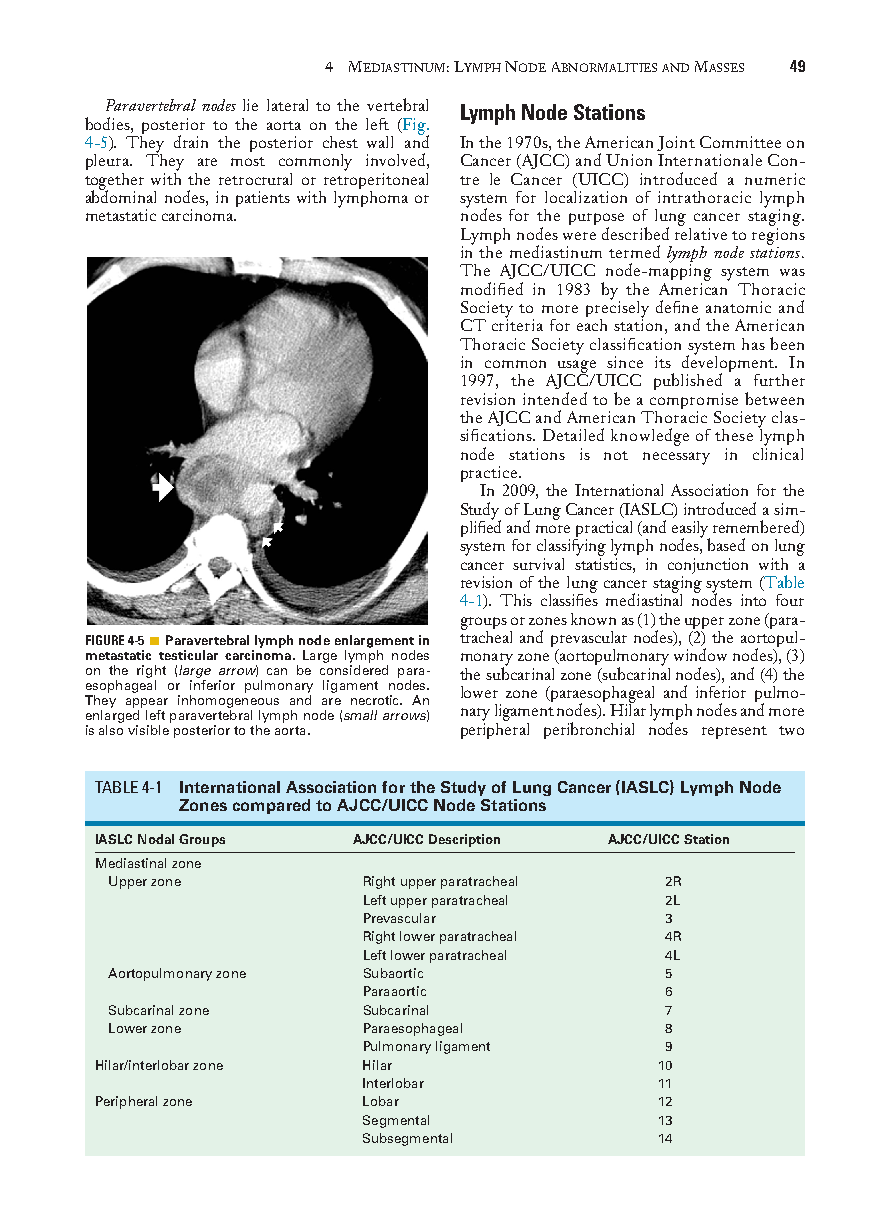

In [38]:
import pdfplumber
pdf = pdfplumber.open('/home/bdrad/Documents/Vogel/book-scrape/scrape/Chest - Webb - Fundamentals of Body CT (4e).pdf')
pg = pdf.pages[52]
im = pg.to_image(resolution=300).original
pg.to_image(resolution=120).original
# im.save("test2.png")

In [2]:
from docxchain.pipelines.document_structurization import DocumentStructurization
from docxchain.utilities.visualization import document_structurization_visualization

configs = dict(
    layout_analysis_configs = dict(
        from_modelscope_flag=False,
        model_path='/home/DocXLayout_231012.pth',
    ),
    text_detection_configs = dict(
        from_modelscope_flag=True,
        model_path='damo/cv_resnet18_ocr-detection-line-level_damo',
    ),
    text_recognition_configs = dict(
        from_modelscope_flag=True,
        model_path='damo/cv_convnextTiny_ocr-recognition-document_damo',  # alternatives: 'damo/cv_convnextTiny_ocr-recognition-scene_damo', 'damo/cv_convnextTiny_ocr-recognition-general_damo', 'damo/cv_convnextTiny_ocr-recognition-handwritten_damo'
    ),
    formula_recognition_configs = dict(
        from_modelscope_flag=False,
        image_resizer_path='/home/LaTeX-OCR_image_resizer.onnx',
        encoder_path='/home/LaTeX-OCR_encoder.onnx',
        decoder_path='/home/LaTeX-OCR_decoder.onnx',
        tokenizer_json='/home/LaTeX-OCR_tokenizer.json',
    ),
)

# TODO specify which GPU, rather than hardcoding -- see BaseDetector init

document_structurizer = DocumentStructurization(configs)

2024-02-18 16:53:07,211 - modelscope - INFO - PyTorch version 2.0.1 Found.
2024-02-18 16:53:07,214 - modelscope - INFO - TensorFlow version 2.10.0 Found.
2024-02-18 16:53:07,215 - modelscope - INFO - Loading ast index from /home/bdrad/.cache/modelscope/ast_indexer
2024-02-18 16:53:07,245 - modelscope - INFO - Loading done! Current index file version is 1.12.0, with md5 fa65824693d2a8d953c44638edf14874 and a total number of 964 components indexed
/home/bdrad/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-18 16:53:07.447985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild Tens

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /home/bdrad/Documents/Vogel/book-scrape/docxlayout/../../exp/ctdet_subfield/default
heads {'hm': 11, 'cls': 4, 'ftype': 3, 'wh': 8, 'hm_sub': 2, 'wh_sub': 8, 'reg': 2, 'reg_sub': 2}
--> loading model from local file: /home/DocXLayout_231012.pth
02/18/2024 16:53:11 - INFO - docxlayout.main -   Training parameters {'task': 'ctdet_subfield', 'arch': 'dlav0subfield_34', 'input_res': 768, 'num_classes': 13, 'load_model': '/home/DocXLayout_231012.pth', 'debug': 0, 'gpus': '1'}


2024-02-18 16:53:13,460 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2024-02-18 16:53:18,538 - modelscope - INFO - initiate model from /home/bdrad/.cache/modelscope/hub/damo/cv_resnet18_ocr-detection-line-level_damo
2024-02-18 16:53:18,539 - modelscope - INFO - initiate model from location /home/bdrad/.cache/modelscope/hub/damo/cv_resnet18_ocr-detection-line-level_damo.
2024-02-18 16:53:18,542 - modelscope - WARNING - No preprocessor field found in cfg.
2024-02-18 16:53:18,543 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2024-02-18 16:53:18,544 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': '/home/bdrad/.cache/modelscope/hub/damo/cv_resnet18_ocr-detection-line-level_damo'}. trying to build by task and model information.
2024-02-18 16:53:18,544 - modelscope - WARNING - Find task: ocr-detection, model type: None. Insuffi

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
02/18/2024 16:53:19 - WARNING - tensorflow -   From /home/bdrad/anaconda3/envs/modelscope/lib/python3.8/site-packages/modelscope/utils/device.py:60: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-02-18 16:53:19.031313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-18 16:53:19.031531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-18 16:53:19.031716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-18 16:53:19.031870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-18 16:53:19.032013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
02/18/2024 16:53:20 - WARNING - tensorflow -   From /home/bdrad/anaconda3/envs/modelscope/lib/python3.8/site-packages/modelscope/pipelines/cv/ocr_utils/ops.py:744: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2

2024-02-18 16:53:20,821 - modelscope - INFO - loading model from /home/bdrad/.cache/modelscope/hub/damo/cv_resnet18_ocr-detection-line-level_damo/tf_ckpts/checkpoint-80000


INFO:tensorflow:Restoring parameters from /home/bdrad/.cache/modelscope/hub/damo/cv_resnet18_ocr-detection-line-level_damo/tf_ckpts/checkpoint-80000
02/18/2024 16:53:21 - INFO - tensorflow -   Restoring parameters from /home/bdrad/.cache/modelscope/hub/damo/cv_resnet18_ocr-detection-line-level_damo/tf_ckpts/checkpoint-80000


2024-02-18 16:53:21.059374: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-02-18 16:53:23,162 - modelscope - WARNING - Model revision not specified, use revision: v2.4.0
2024-02-18 16:53:23,656 - modelscope - INFO - initiate model from /home/bdrad/.cache/modelscope/hub/damo/cv_convnextTiny_ocr-recognition-document_damo
2024-02-18 16:53:23,657 - modelscope - INFO - initiate model from location /home/bdrad/.cache/modelscope/hub/damo/cv_convnextTiny_ocr-recognition-document_damo.
2024-02-18 16:53:23,658 - modelscope - INFO - initialize model from /home/bdrad/.cache/modelscope/hub/damo/cv_convnextTiny_ocr-recognition-document_damo
2024-02-18 16:53:25,574 - modelscope - INFO - loading model from dir /home/bdrad/.cache/modelscope/hub/damo/cv_convnextTiny_ocr-recognition-document_damo
2024-02-18 16:53:25,605 - modelscope - INFO - loading model done


In [31]:
# image = 'test.png'
# image = 'test2.png'
# final_result = document_structurizer(image)    # run
final_result = document_structurizer(im_bgd)    # run
print(final_result)
layout = final_result

2024-02-18 17:25:31.267808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-18 17:25:31.268035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-18 17:25:31.268209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-18 17:25:31.268368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-18 17:25:31.268521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

[{'category_index': 0, 'category_name': 'title', 'region_poly': [1143, 256, 1620, 256, 1620, 308, 1143, 308], 'text_list': [{'position': [1149, 254, 1612, 255, 1612, 307, 1149, 306], 'content': ['Lymph Node Stations']}]}, {'category_index': 1, 'category_name': 'figure', 'region_poly': [208, 614, 1086, 614, 1086, 1580, 208, 1580], 'text_list': []}, {'category_index': 2, 'category_name': 'plain text', 'region_poly': [212, 245, 1074, 245, 1074, 567, 212, 567], 'text_list': [{'position': [263, 238, 1078, 241, 1078, 285, 263, 282], 'content': ['Paravertebral nodes lie lateral to the vertebral']}, {'position': [213, 286, 1078, 289, 1078, 330, 213, 327], 'content': ['bodies, posterior to the aorta on the left (Fig.']}, {'position': [213, 331, 1078, 333, 1078, 377, 213, 375], 'content': ['4-5). They drain the posterior chest wall and']}, {'position': [214, 381, 1077, 380, 1077, 423, 214, 424], 'content': ['pleura. They are most commonly involved,']}, {'position': [214, 428, 1077, 427, 1077, 46

In [14]:
final_result

[{'category_index': 0,
  'category_name': 'title',
  'region_poly': [1143, 256, 1620, 256, 1620, 308, 1143, 308],
  'text_list': [{'position': [1149, 254, 1612, 255, 1612, 307, 1149, 306],
    'content': ['']}]},
 {'category_index': 1,
  'category_name': 'figure',
  'region_poly': [208, 614, 1086, 614, 1086, 1580, 208, 1580],
  'text_list': []},
 {'category_index': 2,
  'category_name': 'plain text',
  'region_poly': [212, 245, 1074, 245, 1074, 567, 212, 567],
  'text_list': [{'position': [263, 238, 1078, 241, 1078, 285, 263, 282],
    'content': ['']},
   {'position': [213, 286, 1078, 289, 1078, 330, 213, 327], 'content': ['']},
   {'position': [213, 331, 1078, 333, 1078, 377, 213, 375], 'content': ['']},
   {'position': [214, 381, 1077, 380, 1077, 423, 214, 424], 'content': ['']},
   {'position': [214, 428, 1077, 427, 1077, 469, 214, 470], 'content': ['']},
   {'position': [215, 471, 1077, 475, 1077, 517, 214, 513], 'content': ['']},
   {'position': [204, 525, 592, 526, 592, 556, 204

In [17]:
import cv2
output_image = document_structurization_visualization(final_result, image)    # visualize
cv2.imwrite(image.split(".")[0]+'-parse.png', output_image);
# document_structurizer.release()

In [78]:
from typing import List, Dict, Tuple, Set
from pdfplumber.display import PageImage
import numpy as np
Labels = dict

Label_types = {"title", "figure", "plain text", "header", "page number", "footnote", "footer", "table", "table caption", "figure caption", "equation", "full column", "sub column"}
label_type_ignore = {"page number", "equation"}
label_type_texts = {"title", "plain text", "header", "footnote", "footer" }
label_type_img = {"figure", "table"}


# TODO search for missing text
# * if last label figure and current is text
def _get_labels(im, page, return_split_idx=False, pad=0.01, model=None, layout=None) -> List[Labels]:
    if type(im) is PageImage:
        im = im.annotated.original
    elif isinstance(im, str):
        im = cv2.imread(im, cv2.IMREAD_COLOR)
    if type(im) is not np.ndarray:
        im = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
    assert type(im) is np.ndarray

    w_im, h_im = im.shape[1], im.shape[0]
    w_pg, h_pg = pg.width, pg.height
    w_ratio, h_ratio = w_pg / w_im, h_pg / h_im

    layout = layout or document_structurizer(im)
    # print(layout)

    out = []

    for category in layout:
        idx = category['category_index']
        label_type = category['category_name']
        bbox = category['region_poly']
        bbox = np.array(bbox).reshape(-1, 2)
        x0,y0,x1,y1 = bbox[:,0].min(), bbox[:,1].min(), bbox[:,0].max(), bbox[:,1].max()
        assert x0 < x1 and y0 < y1
        bbox = (x0, y0, x1, y1)
        x0, x1 = x0 * w_ratio, x1 * w_ratio
        y0, y1 = y0 * h_ratio, y1 * h_ratio
        # bbox = (x0, h_pg - y1, x1, h_pg - y0)
        pW = pad * w_im / 8
        pH = pad * h_im / 16
        x0, x1 = x0 - pW, x1 + pW
        y0, y1 = y0 - pH, y1 + pH
        area = page.within_bbox((x0, y0, x1, y1), strict=False, relative=True)
        # if type is text:
        txt = area.extract_text()
        # elif type is figure/table
        area.to_image(resolution=300).original.save(f"testframe-{idx}.png")

        label = dict(id=idx,label_type=label_type,bbox=bbox,txt=txt)
        out.append(label)
        # print('===\n',idx, label_type, txt)
        # category['text_list']

    # TODO add to cfg one/two column choice and implement here
    def _sort_labels(labels: List[Labels], left_pad=0.98) -> List[Labels]:
        left_width = left_pad * w_im / 2
        left_blocks = [l for l in labels if l['bbox'][0] < left_width]
        right_blocks = [b for b in labels if b not in left_blocks]        # conjugates

        sort_key = lambda b: b['bbox'][1]  # sort by top-most y
        left_blocks = sorted(left_blocks, key=sort_key)
        right_blocks = sorted(right_blocks, key=sort_key)

        blocks = left_blocks + right_blocks

        for i, b in enumerate(blocks):
            b['id']=i

            # for c in blocks[:i] + blocks[i + 1 :]:  # get all but b
            #     if b.is_in(c, center=True):
            #         # later on, parent used as idicator to skip
            #         b = b.set(parent=c.id)
        # print([(b['label_type'],b['bbox'][:-2]) for b in left_blocks])
        # print([(b['label_type'],b['bbox'][:-2]) for b in right_blocks])

        if return_split_idx:
            return blocks, len(left_blocks)
        return blocks


    out = _sort_labels(out)
    return out

labels = _get_labels(im, pg, layout=layout)
for l in labels:
    id, label_type, bbox, txt = l.values()
    print("===\n"+str(id), label_type, txt)

===
0 header 4 MediastinuM: LyMph node abnorMaLities and Masses
===
1 plain text Paravertebral nodes lie lateral to the vertebral
bodies, posterior to the aorta on the left (Fig.
4-5). They drain the posterior chest wall and
pleura. They are most commonly involved,
together with the retrocrural or retroperitoneal
abdominal nodes, in patients with lymphoma or
metastatic carcinoma.
===
2 figure 
===
3 plain text FIGURE 4-5 n Paravertebral lymph node enlargement in
metastatic testicular carcinoma. Large lymph nodes
on the right (large arrow) can be considered para­
esophageal or inferior pulmonary ligament nodes.
They appear inhomogeneous and are necrotic. An
enlarged left paravertebral lymph node (small arrows)
is also visible posterior to the aorta.
===
4 table caption TABLE 4-1 International Association for the Study of Lung Cancer (IASLC) Lymph Node
Zones compared to AJCC/UICC Node Stations
===
5 table IASLC Nodal Groups AJCC/UICC Description AJCC/UICC Station
Mediastinal zone
Upper z

## layout parser

[detectron2 config](https://detectron2.readthedocs.io/en/latest/modules/config.html#yaml-config-references)

In [2]:
model = None
del model
model = lp.models.Detectron2LayoutModel(
    # 'lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
    'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
    # extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.9],
    # extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.77],
    # extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.72],
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7],
    # extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
)

NameError: name 'lp' is not defined

## tracker

In [23]:
from collections import defaultdict

class ChapterEntry(defaultdict):

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    # body_font = set()
    # header_font = set()
    # label_end = label_start = -1
    # pg_end = pg_start = pg_curr = -1

TOK_LABEL_END = '[LABEL_END]'
TOK_STARTUP = '[STARTUP]'
TOK_FONTBREAK = '[FONTBREAK]'
TOK_NOFONT = ('[NOFONT]', -1)

TRACKER_MODES = {'startup', 'header', 'body'}
LABEL_MODES = {'Title', 'Text'}

/home/bdrad/Documents/Vogel/book-scrape/.venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


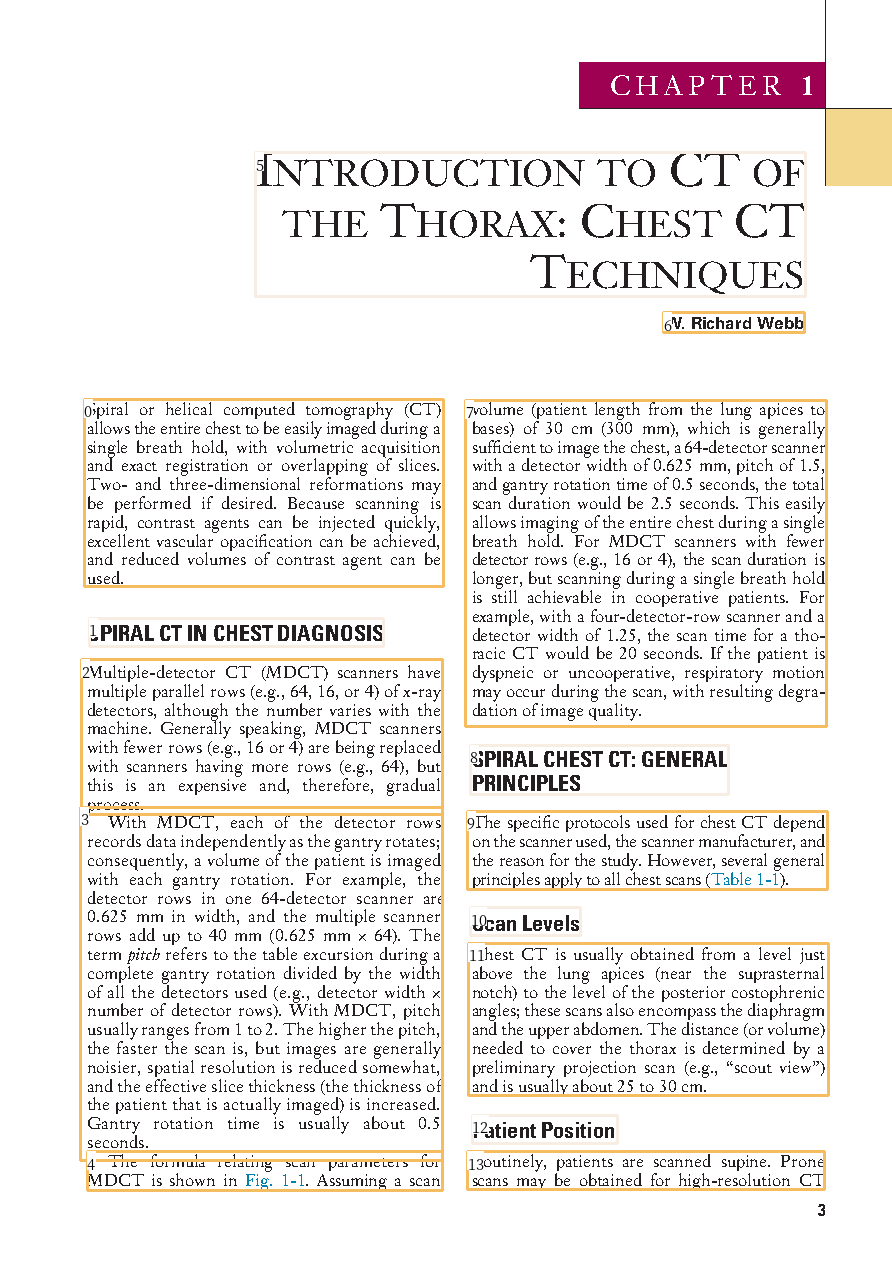

In [24]:
from layoutparser.elements import Layout, Interval
from pdfplumber.page import Page
from pdfplumber.display import PageImage

def get_labels(im, return_split_idx=False, pad=0.05) -> Layout:
# def get_labels(pg, resolution=123) -> Layout:
    # im = pg.to_image(resolution=resolution).annotated
    if type(im) is PageImage:
        im = im.annotated

    w,h = im.size

    layout = model.detect(im) # Detect the layout of the input image

    text_blocks: Layout = lp.Layout([b for b in layout if b.type in ('Text', 'Title')])
    nontext_blocks: Layout = lp.Layout([b for b in layout if b.type in ('Figure', 'Table')])

    # As there could be text region detected inside the figure region, we just drop them:
    text_blocks: Layout = lp.Layout([b for b in text_blocks if not any(b.is_in(b_fig, center=True) for b_fig in nontext_blocks)])

    # canvas_height=h, canvas_width=w
    left_interval: Interval = lp.Interval(0, w/2*(1.0+pad), axis='x').put_on_canvas(im)

    left_blocks = text_blocks.filter_by(left_interval, center=True)
    right_blocks = [b for b in text_blocks if b not in left_blocks]

    sort_key = lambda b: b.coordinates[1]
    left_blocks = sorted(left_blocks, key=sort_key)
    right_blocks = sorted(right_blocks, key=sort_key)
    text_blocks = [b.set(id=idx) for idx, b in enumerate(left_blocks + right_blocks)]

    for i, b in enumerate(text_blocks):
        for c in text_blocks[:i] + text_blocks[i+1:]:   # get all but b
            if b.is_in(c, center=True):
                b = b.set(parent=c.id)
                print(f"%%% Text block {b.id} is inside {b.parent} -- skipping")

    if return_split_idx:
        return text_blocks, len(left_blocks)
    else:
        return text_blocks



pg = pages[0]
im = pg.to_image(resolution=123).annotated
sorted_boxes = get_labels(im)

lp.draw_box(im, sorted_boxes, box_width=3, show_element_id=True)

In [25]:
# TODO better way to manage these -- write to config file?
# perhaps we do pre-processing, purely on filling these sets (i.e. fonts that appear in tables, and never in body/header, we should always ignore)

font_blacklist: Set[Tuple[str, float]] = set()
font_bodies: Set[Tuple[str, float]] = set()
font_headers: Set[Tuple[str, float]] = set()
font_tables: Set[Tuple[str, float]] = set()

def font_category(fonts: List[Tuple[str, float]]) -> str:
    # TODO track avg font size for each
    cnt_header = sum([font in font_headers for font in fonts])
    cnt_body = sum([font in font_bodies for font in fonts])
    return 'body' if cnt_body > cnt_header else 'header'

In [26]:
def clip_overlap(body, txt):
    # Find the longest common suffix between body and txt
    overlap = 0
    body, txt = body.rstrip(), txt.lstrip()
    for i in range(1, min(len(body), len(txt))+1):
        if body[-i:] == txt[:i]:
            overlap = i
    # rt the non-overlapping part of txt to body
    return txt[overlap:]

class ChapterTracker:
    skip_interruping_header = True
    skip_font_label_mismatch = False    # issue: causes skip_interrupting_header to be ignored
    assert skip_interruping_header and skip_font_label_mismatch is False
    multifont_new_entry = False         # not implemented
    close_rstrip = True
    clean_merge = False  # ensure there is a single space between existing text and the new entry

    early_exit_txts = ('SUGGESTED READING')


    def  __init__(self, mode='startup', entries: List[dict]=None) -> None:
        self.mode = mode
        assert self.mode in TRACKER_MODES
        self.entries: List[ChapterEntry] = entries or []    # having the argument as a list mutates it; copies chapter-to-chapter entries.
        self.header = self.body = ''
        self.body_font = set()
        self.header_font = set()
        self.label_end = self.label_start = -1
        self.pg_end = self.pg_start = self.pg_curr = -1

    @property
    def current_font(self):
        return self.header_font if self.mode == 'header' else self.body_font

    def close(self):
        if self.body == self.header == '':
            return
        if self.mode != 'body':
            print(f"### Closed while in {self.mode} -- we should only close when in `body` mode")
        if self.close_rstrip:
            self.header, self.body = self.header.rstrip(), self.body.rstrip()
        self.header_font, self.body_font = self.header_font or [TOK_NOFONT], self.body_font or [TOK_NOFONT]
        self.entries.append(dict(
                label_range=[self.label_start, self.label_end], pg_range=[self.pg_start, self.pg_end],
                header_font=self.header_font, header=self.header, body_font=self.body_font, body=self.body)
            )
        self.__init__(entries=self.entries)

    def get_entries(self) -> List[ChapterEntry]:
        self.close()
        return self.entries

    def font_log(self, fonts: List[Tuple[str, float]], mode, k=4):
        inner_font = r'^([A-Z]+)\+(\w+?)-(\w+?)$'
        fonts = [((re.sub(inner_font, r'\2', font) if re.search(inner_font, font) else inner_font), size) for font, size in fonts]

        if mode == 'header':
            font_headers.union(fonts)
        else:
            font_bodies.union(fonts)

    def font_parse(self, label_type, fonts: List[Tuple[str, float]], txt) -> bool:
        assert label_type in LABEL_MODES
        label_mode = 'header' if label_type == 'Title' else 'body'

        if len(fonts)>1 and self.multifont_new_entry:   # and any([font in others for font in fonts])
            raise NotImplementedError
            return False
        # if not (self.header_font if self.mode == 'header' else self.body_font):
        if not self.current_font: # ! this line breaks ?
            if label_mode=='header':
                self.header_font = set([max(fonts, key=lambda f: f[1])]) # largest font
            else:
                self.body_font = set([fonts[0]])   # most frequent font
            return True
        else:
            if font_category(fonts) != label_mode:
                if self.skip_font_label_mismatch:
                    self.close()
                    self.body_font = set(fonts)
                    self.header_font = set(fonts)
                    self.header = TOK_FONTBREAK
                    self.body = txt
                    self.mode = "body"
                return False
            if label_mode=='header':
                self.header_font.add(max(fonts, key=lambda f: f[1]))
            else:
                self.body_font.add(fonts[0])

        return True

    def add_txt(self, txt: str, label_type: str, fonts: List[Tuple[str, float]], pg_num: int, label_num: int):
        assert label_type in LABEL_MODES
        if not txt: return
        txt = process_text(txt) # pg_num=pg_num
        if not txt: return

        if any([font in font_blacklist for font in fonts]):
            print(f'!!! blacklisted font, skipping `{txt}`')
            return


        log_font_mode: str = None
        # mode to which the font will be logged to
        # only set if confident the label correctly matches, i.e. we are extending the entry

        if txt in self.early_exit_txts:
            self.close()
            return

        if label_type == "Title":
            if self.mode == "header":
                txt = clip_overlap(self.header, txt)
                if self.clean_merge:
                    self.header = self.header.rstrip() + " " + txt.lstrip()
                else:
                    self.header += txt
            else:
                if not ends_with(self.body) and self.skip_interruping_header and pg_num == self.pg_curr:
                    print(f'>>> interrupting header, skipping `{txt}`')
                    return
                txt = clip_overlap(self.body, txt)
                self.close()
                self.header = txt
                self.mode = "header"
            log_font_mode = "header"

        elif label_type == "Text":
            if txt.endswith(TOK_SENTENCE_TERMS):
                # txt += (f"\n {TOK_LABEL_END} \n" if TOK_LABEL_END else '\n')
                txt += '\n'
            if self.mode == 'header':
                txt = clip_overlap(self.header, txt)
                self.body = txt
                log_font_mode = "body"
            else:
                if self.mode == "body":
                    self.log_font_mode = "body"
                if self.mode == "startup" and self.header == '':
                    self.header = TOK_STARTUP
                else:
                    txt = clip_overlap(self.body, txt)
                if not re.search(r"\s+$", self.body) and not re.search(r"^\s+", txt):
                    txt = " " + txt # insert space if existing body doesn't end with whitespace
                if self.clean_merge:
                    self.body = self.body.rstrip() + " " + txt.lstrip()
                else:
                    self.body += txt
            self.mode = "body"

        if self.pg_curr < pg_num:
            self.pg_curr = pg_num

        if self.pg_start < 0:
            self.pg_start = pg_num
        if self.label_start < 0:
            self.label_start = label_num

        self.pg_end, self.label_end = pg_num, label_num

        if not self.font_parse(label_type, fonts, txt):
            # this works now, but should be placed above
            # to raise an error when the current font isn't in [body/header]_font
            return
        if log_font_mode:
            self.font_log(fonts, log_font_mode)

## main

In [28]:
from layoutparser.elements import TextBlock
from tqdm.notebook import tqdm
import json

def process_file_tracker(
    fname: Path,
    pad=0.010,
    # pad=0.0075,
    # pad=0.006,
    resolution=123,
    laparams=dict(detect_vertical=False)
    # laparams=dict(detect_vertical=False, word_margin=0.08)    # this doesn't cause any difference?
):
    assert 0<=pad<1

    pdf = pdfplumber.open(fname, laparams=laparams).pages

    outdir = Path("scrape_out")
    outdir /= fname.stem
    outdir.mkdir(exist_ok=True)

    config = Config(fname)
    # chapters = [config.chapter_range()[0]]
    chapters = config.chapter_range()
    for i, ch in enumerate(chapters,1):
        print(f"Processing ch{i}")
        start, end = ch
        pages = pdf[start:end]
        tracker = ChapterTracker()

        progress = tqdm(pages)
        for pg in progress:
            pg_num = pg.page_number
            im = pg.to_image(resolution=resolution).annotated
            w_im,h_im = im.size
            w_pg,h_pg = pg.width,pg.height
            w_ratio,h_ratio = w_pg/w_im,h_pg/h_im

            labels = get_labels(im)
            for label_num, label in enumerate(labels):
                # print(label)
                label: TextBlock
                if label.parent is not None:
                    print(f"%%% Text block {label.id} is inside {label.parent} -- skipping")
                    continue
                pad_x, pad_y = pad*w_im, pad*h_im
                label = label.pad(left=pad_x, right=pad_x, top=pad_y, bottom=pad_y)
                x0,y0,x1,y1 = label.coordinates
                x0,x1 = x0*w_ratio, x1*w_ratio
                y0,y1 = y0*h_ratio, y1*h_ratio
                # x0,x1 = (x0-pad*w_im)*w_ratio, (x1+pad*w_im)*w_ratio
                # y0,y1 = (y0-pad*h_im)*h_ratio, (y1+pad*h_im)*h_ratio

                kind = label.type
                # assert kind in ("Text", "Title")

                area = pg.within_bbox((x0,y0,x1,y1))
                fonts = extract_fonts(area)
                txt = area.extract_text()
                tracker.add_txt(txt, kind, fonts, pg_num, label_num)

        tracker.close()


        with open(outdir / f"ch{i}_tracker.json", "w", encoding="utf8") as f:
            print(f"*** saving to {f.name}")
            data = tracker.get_entries()
            data = [{k: (list(v) if type(v) is set else v) for k,v in entry.items()} for entry in data] # json-ify: tuples -> lists

            # json.dump(data, f, indent=2, ensure_ascii=False)
            s = json.dumps(data, indent=2, ensure_ascii=False)
            s = compact_json(s)
            f.write(s)

process_file_tracker(fname)

Processing ch1


  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# process_file_tracker(fname)

# post processing

- everything we can't greedily use regex for
- detect..
    - conjugated words
    - figures
    - skipped/missing text
    - out of order sentences
    - duplicated sentences
- for these capabilities, will need to log font size+family+relative position of each textbox
- should also have some method to catch skipped boxes (i.e. those not recognized by layout parser OCR -- notably lists are buggy)

In [ ]:
# TODO

# appendix

## example snippets

### extract fonts

In [ ]:
box = sorted_boxes[13]
print(box)
x0,y0,x1,y1 = box.coordinates

w_im,h_im = im.size
w_pg,h_pg = pg.width,pg.height
w_ratio,h_ratio = w_pg/w_im,h_pg/h_im
pad=0.005
x0,x1 = (x0-pad*w_im)*w_ratio, (x1+pad*w_im)*w_ratio
y0,y1 = (y0-pad*h_im)*h_ratio, (y1+pad*h_im)*h_ratio

y1 *= 1

area = pg.within_bbox((x0,y0,x1,y1))
area_im = area.to_image(resolution=123).annotated
plt.imshow(area_im)
extract_fonts(area)

### layout parser 

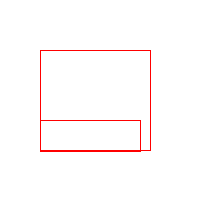

In [ ]:
import layoutparser as lp
import numpy as np

# block_A = lp.Rectangle(50, 50, 150, 150)
# block_B = lp.Rectangle(40, 60, 160, 30)
block_A = lp.Rectangle(40, 50, 150, 150)
block_B = lp.Rectangle(40, 120, 140, 151)

lp.draw_box(np.ones((200,200,3), dtype='uint8')*255, [block_A, block_B])

In [ ]:
print(block_A.is_in(block_B))
print(block_B.is_in(block_A))
print(block_A.is_in(block_B, center=True))
print(block_B.is_in(block_A, center=True))

False
False
False
True


## unfinished/broken/abandoned code

### overlap detection 

- current approach with layoutparser seems good enough
- this 'manual' approach is  not done

** ignoring overlap case (contained)
1 1 8 12
6 2 11 10


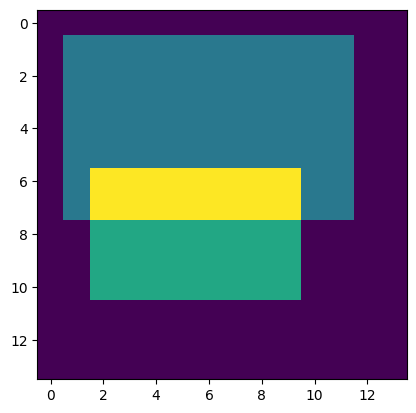

In [ ]:
# TODO finish this
import numpy as np
import matplotlib.pyplot as plt
from math import ceil,floor

def place(i,j,data,itm,center=False):
    h,w=itm.shape

    if center:
        i-=h//2
        j-=w//2

    data[i:i+h,j:j+w]+=itm
    return data

def rm_overlap(rect0: List[int],rect1: List[int], favor=0, interp=0.66) -> Tuple[List[int], List[int]]:
    assert 0<=interp<=1

    x0,y0,x1,y1=rect0
    a0,b0,a1,b1=rect1

    # no overlap
    if x1<a0 or a1<x0 or y1<b0 or b1<y0:
        return rect0, rect1

    # boxes overlap in x, and y
    if not (x1<a0 or a1<x0) and not (y1<b0 or b1<y0):
        p,q=interp,1-interp

        if y0<b0<y1<b1:     # rect0 above rect1
            margin = y1-b0
            y1-=margin*(q if favor else p)
            b0+=margin*(p if favor else q)
            y1,b0=floor(y1),ceil(b0)
        elif b0<y0<b1<y1:   # rect0 below rect1
            margin = b1-y0
            y0+=margin*(q if favor else p)
            b1-=margin*(p if favor else q)
            y0,b1=ceil(y0),floor(b1)
        else:
            print('** ignoring overlap case (contained)')

    # y0,b0=max(y0,0),max(b0,0)
    return [x0,y0,x1,y1], [a0,b0,a1,b1]


n = 14
data = np.zeros((n,n))

a_dim = (7,11)
a_off = (1,1)
a = np.ones(a_dim)/3.0
ax0,ay0 = a_off
ax1,ay1 = [a+i for a,i in zip(a_off,a.shape)]


b_dim = (5,8)
b_off = (6,2)
b = np.ones(b_dim)/2.0
bx0,by0 = b_off
bx1,by1 = [b+i for b,i in zip(b_off,b.shape)]

(ax0,ay0,ax1,ay1), (bx0,by0,bx1,by1) = rm_overlap((ax0,ay0,ax1,ay1), (bx0,by0,bx1,by1))
place(*a_off,data,a)
print(ax0,ay0,ax1,ay1)
place(*b_off,data,b)
print(bx0,by0,bx1,by1)

plt.imshow(data, interpolation='nearest');

### typing entry

In [ ]:
from typing import TypedDict
from collections import defaultdict

class ChapterEntry(defaultdict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    header_font: List[Tuple[str, float]]
    header: str
    body_font: List[Tuple[str, float]]
    body: str
    label_start: int
    label_end: int
    pg_start: int
    pg_end: int
# type FontPair = Tuple[str, float]     # need python 3.12

## old code

### `pdfplumber`

In [ ]:
import pdfplumber

pdf = pdfplumber.open(fname, laparams={"detect_vertical": False}).pages

In [167]:
start, end = config.chapter_range()[0]
pages = pdf[start:end]
pg = pages[3]
pg.to_image(resolution=123).draw_rects(pg.textboxhorizontals).show()

In [171]:
# text = pg.extract_text()
# print(text)

words = pg.extract_words()
words = pg.extract_words(use_text_flow=True, x_tolerance=7, keep_blank_chars=True)
print("".join([w['text'] for w in words]))

Chapter 1: Diagnostic Imaging Methods 5AB   FIGURE 1.6 .  Image Matrix. A.  Magnifi ed CT image of a pulmonary nodule ( N ). The pixels that make up the image are evident as tiny squares within the image. The window width is set at 2000 H with a window level of  (cid:3) 600 H to accentuate visualization of the white soft-tissue nodule on a background of gray, air-fi lled lung.  B.  Diagram of the matrix that constitutes the CT image. A pixel from air-fi lled lung with a calculated CT number of  (cid:3) 524 H is gray, whereas a pixel from the soft-tissue nodule with a calculated CT number of  (cid:4) 46 H is white. gray shades. The middle gray shade is assigned to the pixel values centered on a selected  window level . Pixels with values greater than the upper limit of the window width are displayed white, and pixels with values less than the lower limit of the window width are displayed black. To analyze optimally all of the anatomic information of any particular slice, the image is vi

In [65]:
from layoutparser.elements import TextBlock

def process_page_DNN(pg: Page, pad=0.005, resolution=123):
    assert 0<=pad<1
    continuation = ""   # base text continuing from previous page's last entry
    mode = "startup"    # startup, header, body
    entries = []        # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)
    done = False        # whether we've reached the end of the chapter (e.x. sugguested readings section)

    SKIP_BADPUNC = True

    pg_num = pg.page_number
    im = pg.to_image(resolution=resolution).annotated
    labels = get_labels(im)

    w_im,h_im = im.size
    w_pg,h_pg = pg.width,pg.height
    w_ratio,h_ratio = w_pg/w_im,h_pg/h_im

    for j,label in enumerate(labels):
        label: TextBlock
        pad_x, pad_y = pad*w_im, pad*h_im
        label = label.pad(left=pad_x, right=pad_x, top=pad_y, bottom=pad_y)
        # print(label)

        kind = label.type
        assert kind in ("Text", "Title")

        x0,y0,x1,y1 = label.coordinates
        x0,x1 = x0*w_ratio, x1*w_ratio
        y0,y1 = y0*h_ratio, y1*h_ratio
        # x0,x1 = (x0-pad*w_im)*w_ratio, (x1+pad*w_im)*w_ratio
        # y0,y1 = (y0-pad*h_im)*h_ratio, (y1+pad*h_im)*h_ratio

        # TODO detect+rm overlap (ensure text is not duplicated)
        # section = pg.crop((x0,y0,x1,y1))
        # sec = section.to_image(resolution=123).annotated
        # plt.imshow(sec)
        # display(sec)

        area = pg.within_bbox((x0,y0,x1,y1), strict=False)
        fonts = extract_fonts(pg)   # TODO continue iff font matches previous
        txt = area.extract_text()
        # print(txt)
        txt = process_text(txt, pg_num=pg_num)
        # print(txt)

        if txt == 'SUGGESTED READING':
            print(f'### PG {pg_num} :: Found end of chapter, stopping early ###')
            done = True
            if mode == "body":
                entries.append(current_entry)
                # entries.append([ent.rstrip() for ent in current_entry])
            return entries, continuation.rstrip(), done

        if kind == "Title":
            match mode:
                case "header":
                    current_entry[0] += txt
                case "startup":
                    if continuation!="" and not continuation.rstrip().endswith(TOK_SENTENCE_TERMS):
                        print(f'### PG {pg_num}, Box {j} :: Continuation does not end with punctuation: {continuation.rstrip()[-1]}')
                        if SKIP_BADPUNC:
                            print(f'### > skipping `{txt}`')
                            continue
                    mode = "header"
                    current_entry = [txt, ""]
                case "body":
                    if current_entry[1]!="" and not current_entry[1].rstrip().endswith(TOK_SENTENCE_TERMS):
                        print(f'### PG {pg_num}, Box {j} :: Body does not end with punctuation: {current_entry[1].rstrip()[-1]}')
                        if SKIP_BADPUNC:
                            print(f'### > skipping `{txt}`')
                            continue
                    mode = "header"
                    entries.append(current_entry)
                    # entries.append([ent.rstrip() for ent in current_entry])
                    current_entry = [txt, ""]
        elif kind == "Text":
            match mode:
                case "header":
                    mode = "body"
                    current_entry[1] += txt
                case "startup":
                    if txt.endswith(TOK_SENTENCE_TERMS):
                        txt += "\n"
                    continuation += txt
                case "body":
                    # if re.match(r'[.?!]', txt[-1]):
                    if txt.endswith(TOK_SENTENCE_TERMS):
                        txt += "\n"
                    current_entry[1] += txt

    match mode:
        case "body":
            # entries.append([ent.rstrip() for ent in current_entry])
            entries.append(current_entry)
        case "header", "startup":
            print("### Ended on", mode, "-- this should not happen")


    continuation = process_text(continuation)
    for i, (_h, b) in enumerate(entries):
        entries[i][1] = process_text(b)

    return entries, continuation, done

In [ ]:
ent, cont, done = process_page_DNN(pg)

print('\n' + '='*60)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()


cont: D, At this level, the azygos arch is usually visibl
arising from the posterior aspect of the superior vena cava, contacting the right mediastinal pleura, and forming th
lateral margin of the node bearing pretracheal space. Fat visible under the aortic arch but above the pulmonary arter
is in the aortopulmonary window, which also contains lymph nodes. AA, ascending aorta; DA, descending aorta; in
mamm, internal mammary; T, trachea. E, Diagram of the mediastinal anatomy at the azygos arch and aortopulmonar
window level.
may be difficult, unless the esophagus contains air
or contrast material. At levels below the subcarinal space, the appearance of the azygoesophageal
recess is relatively constant, although it narrows
somewhat in the retrocardiac region.
or contrast material. At levels below the subcari Also at or near this level, the main pulmonary
artery divides into its right and left branches. The
left pulmonary artery is somewhat
higher than the right, usually seen 1 cm above 

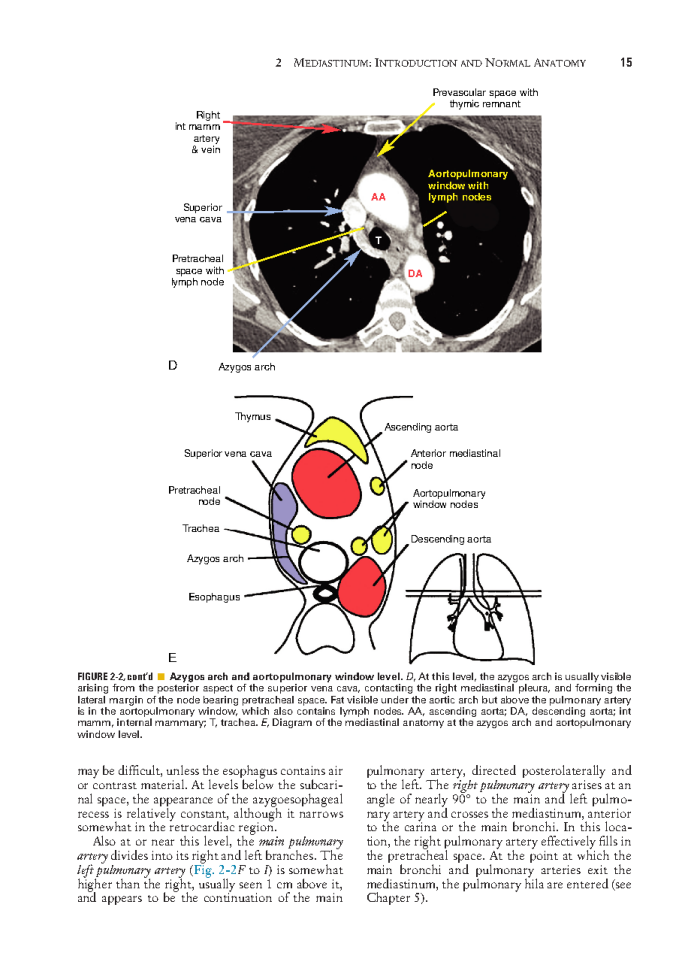

In [ ]:
im = pg.to_image(resolution=123).annotated
plt.figure(figsize=(10,10), dpi=123)
plt.axis("off")
plt.imshow(im);

In [ ]:
from tqdm.notebook import tqdm
import json

def process_file(fname: Path):
    config = Config(fname)
    chapters = config.chapter_range()
    # chapters = [config.chapter_range()[0]]
    pdf = pdfplumber.open(fname, laparams=dict(detect_vertical=False)).pages
    # word_margin=0.08  -- this doesn't cause any difference?

    for i, ch in enumerate(chapters,1):
        # pdf: fitz.Document = fitz.open(fname)
        # pdf.select(range(*ch))

        start, end = ch
        pages = pdf[start:end]

        print(f"Processing ch{i}")

        ch_entries = []

        progress = tqdm(pages)
        for pg in progress:
        # for pg in pdf:
            entries, cont, done = process_page_DNN(pg)
            # entries, cont, done = process_page(pg)

            if cont:
                if len(ch_entries):
                    ch_entries[-1][1] = ch_entries[-1][1] + cont
                else:
                    ch_entries.append(["[Chapter Introduction]", cont])

            ch_entries += entries

            if done:
                progress.close()
                break

        outdir = Path("scrape_out")
        outdir /= fname.stem
        outdir.mkdir(exist_ok=True)
        with open(outdir / f"ch{i}.json", "w", encoding="utf8") as f:
            json.dump(ch_entries, f, indent=False, ensure_ascii=False)
            print(f"Saved to {f.name}")

process_file(fname)

Processing ch1


  0%|          | 0/6 [00:00<?, ?it/s]

### PG 7, Box 6 :: Body does not end with punctuation: n
### > skipping `I ct
ntroduct Ion to of
t : c ct
the horax hest
t
echn Iques`
### PG 7, Box 12 :: Body does not end with punctuation: d
### > skipping `Scan Levels`
### PG 8, Box 7 :: Body does not end with punctuation: d
### > skipping `Gantry Rotation Time`
### PG 10 ::  Failed to dehyphenate word: (2.5-or 
###  Failed to dehyphenate word: (2.5-or 
### PG 11 ::  Failed to dehyphenate word: (1.25-mm 
### PG 11, Box 6 :: Body does not end with punctuation: :
### > skipping `Dynamic CT Techniques`
### PG 11, Box 12 :: Body does not end with punctuation: e
### > skipping `Low-Dose CT`
###  Failed to dehyphenate word: (1.25-mm 
### PG 12, Box 1 :: Continuation does not end with punctuation: s
### > skipping `ABLE 1-2 Radiation Dose for Chest CT
Protocols`
### PG 12 :: Found end of chapter, stopping early ###
Saved to scrape_out/Chest - Webb - Fundamentals of Body CT (4e)/ch1.json
Processing ch2


  0%|          | 0/14 [00:00<?, ?it/s]

### PG 13, Box 7 :: Continuation does not end with punctuation: e
### > skipping `NORMAL MEDIASTINAL
ANATOMY`
### PG 13, Box 9 :: Continuation does not end with punctuation: y
### > skipping `M
ediastinu M
ntroduction an
n a
or Mal nato M`


Exception ignored in: <finalize object at 0x7fe65429e7a0; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.11/weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bdrad/Documents/Vogel/book-scrape/.venv/lib/python3.11/site-packages/pypdfium2/internal/bases.py", line 47, in _close_template
    close_func(raw, *args, **kwargs)
  File "/home/bdrad/Documents/Vogel/book-scrape/.venv/lib/python3.11/site-packages/pypdfium2/_helpers/document.py", line 107, in _close_impl
    pdfium_c.FPDF_CloseDocument(raw)
KeyboardInterrupt: 


### PG 25, Box 9 :: Continuation does not end with punctuation: s
### > skipping `Pericardium`
### PG 26 :: Found end of chapter, stopping early ###
Saved to scrape_out/Chest - Webb - Fundamentals of Body CT (4e)/ch2.json
Processing ch3


  0%|          | 0/23 [00:00<?, ?it/s]

### PG 27, Box 8 :: Body does not end with punctuation: e
### > skipping `: V
ediastinu M ascula
a
bnor Malities an`
### PG 27, Box 10 :: Body does not end with punctuation: b
### > skipping `Right Aortic Arch`
### PG 27, Box 15 :: Body does not end with punctuation: h
### > skipping `Double Aortic Arch`
### PG 29, Box 5 :: Continuation does not end with punctuation: ,
### > skipping `Aortic Aneurysm`
### PG 32, Box 13 :: Body does not end with punctuation: e
### > skipping `Aortic Dissection`
### PG 34 ::  Failed to dehyphenate word: (ECG)-gated 
### PG 34 ::  Failed to dehyphenate word: (1.25-or 
###  Failed to dehyphenate word: (ECG)-gated 
###  Failed to dehyphenate word: (1.25-or 
### PG 36, Box 8 :: Continuation does not end with punctuation: e
### > skipping `Penetrating Atherosclerotic Ulcer`
### PG 37, Box 6 :: Body does not end with punctuation: r
### > skipping `Persistent Left Superior Vena Cava`
### PG 40, Box 16 :: Body does not end with punctuation: r
### > skipping `Pul

  0%|          | 0/24 [00:00<?, ?it/s]

### PG 50, Box 2 :: Body does not end with punctuation: b
### > skipping `LYMPH NODE GROUPS`
### PG 50, Box 15 :: Body does not end with punctuation: s
### > skipping `Middle Mediastinal Nodes`
### PG 53, Box 8 :: Body does not end with punctuation: s
### > skipping `Lymph Node Stations`
### PG 54, Box 1 :: Continuation does not end with punctuation: )
### > skipping `additional groups. `
### PG 54, Box 2 :: Continuation does not end with punctuation: )
### > skipping `CT APPEARANCE OF LYMPH
NODES`
### PG 55, Box 5 :: Body does not end with punctuation: t
### > skipping `Lymph Node Enlargement`
### PG 55, Box 14 :: Body does not end with punctuation: o
### > skipping `Low-Attenuation or Necrotic
Lymph Nodes`
### PG 56 ::  Failed to dehyphenate word: non–small-cell 
###  Failed to dehyphenate word: non–small-cell 


In [ ]:
from pdfplumber.page import Page
from collections import deque

def process_page(pg: Page):
    assert not isinstance(pg, pdfplumber.page.CroppedPage)
    assert pg.textboxhorizontals, "Pass `laparams={...}` when opening the PDF file"

    if (pg.page_number % 2) and config["odd_spread"]:
        crop_box = (
            config["crop_outer"],
            config["crop_top"],
            pg.width - config["crop_inner"],
            pg.height - config["crop_bot"],
        )
    else:
        crop_box = (
            config["crop_inner"],
            config["crop_top"],
            pg.width - config["crop_outer"],
            pg.height - config["crop_bot"],
        )

    pg_crop = pg.within_bbox(crop_box)
    # pg.to_image(resolution=123).draw_rects(pg_crop.textboxhorizontals).show()
    # pg.to_image(resolution=123).draw_rects(pg_crop.extract_words()).show()

    continuation = ""  # base text continuing from previous page's last entry
    mode = "startup"  # startup, header, body
    entries = []  # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)

    last_y = float("inf")

    # todo can I pass args s.t. this correctly parses two columns; or figure out how to order via x0/x1
    for i, box in enumerate(pg_crop.textboxhorizontals):  # [26:27]
        # text = box['text']
        # text = re.sub(r'\n', ' ', text)
        # text = re.sub(r'\s+', ' ', text)
        # words = text.split()
        # print(words)
        # if len(words) < 4: continue

        x0, y0, x1, y1 = box["x0"], box["y0"], box["x1"], box["y1"]
        bbox = (x0, pg.height - y1, x1, pg.height - y0)  # = (x0, y0, x1, y1)
        pg_bbox = pg.crop(bbox, relative=True)

        if mode == "body" and not (
            abs(y1 - last_y) > 0.8 * pg.height
        ):  # condition of text continuation across columns
            current_entry[1] += "\n"

        last_y = y0

        chars = deque(
            [
                c
                for c in pg_bbox.chars
                if c["fontname"] not in config["font_ignore_names"]
            ]
        )
        # print([c for c in pg_bbox.chars if c['fontname'] in config["font_ignore_names"]])
        words = pg_bbox.extract_words()

        # pg_bbox.to_image(resolution=150).draw_rects(chars).show()

        for w in words:
            # ! TODO Find a better way to do this
            try:
                while not w["text"][0].startswith(chars[0]["text"]):
                    # print(w["text"], chars[0]["text"])
                    chars.popleft()

                # if chars:
                #     chars.popleft()
            except IndexError as e:
                #  "".join([w["text"] for w in words])
                print(f"Box {i}: Could not parse the box of text: {e}")
                print(" ".join([w["text"] for w in words]))
                print("".join([c["text"] for c in pg_bbox.chars]))
                break

            txt = w["text"].strip()
            if txt.endswith("-") and abs(w["x1"] - x1) < 0.08 * pg.width:
                txt = txt[:-1]
            else:
                txt = txt + " "

            fname = chars[0]["fontname"]
            if fname in config["font_header_names"]:
                match mode:
                    case "startup":
                        mode = "header"
                        current_entry = [txt, ""]
                    case "header":
                        current_entry[0] += txt
                    case "body":
                        mode = "header"
                        entries.append([ent.strip() for ent in current_entry])
                        current_entry = [txt, ""]
            elif fname in config["font_body_names"]:
                match mode:
                    case "startup":
                        continuation += txt
                    case "header":
                        mode = "body"
                        current_entry[1] += txt
                    case "body":
                        current_entry[1] += txt
            elif fname in config["font_ignore_names"]:
                continue
            else:
                print(f"Unknown font {fname}: '{txt}'")
                # pg_bbox.to_image(resolution=123).draw_rects(chars).show()

        # pg_bbox.to_image(resolution=150).show()
        # pg_bbox.to_image(resolution=150).draw_rects(chars).show()

    return entries, continuation


ent, cont = process_page(pg)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()

TypeError: 'Config' object is not subscriptable

### `fitz` 

In [ ]:
class Config:
    # todo typeing for font_* sets
    odd_spread = True  # inner corresponds to right-side of odd pages, left-side of even pages
    crop_top: int = 0
    crop_inner: int = 0
    crop_bot: int = 0
    crop_outer: int = 0
    font_header: Set[Tuple[int, str]] = set()
    font_body: Set[Tuple[int, str]] = set()
    font_ignore: Set[Tuple[int, str]] = set()
    font_ignore_names: Set[str] = set()
    chapters: List[int] = None

    def __init__(self, fname: Path):
        match fname.name:
            case "Chest - Elicker - HRCT of the Lungs 2e.pdf":
                self.crop_top = 65
                self.crop_inner = 40
                self.crop_bot = 30
                self.crop_outer = 40
                self.chapters = [49, 62, 83, 104, 116, 129, 150, 166, 174, 199, 212, 221, 233, 247, 265, 274, 283, 296, 305]

            case "Chest - Felson - Principles of Chest Roentgenology (4e).pdf":
                self.crop_top = 50
                self.crop_inner = 40
                self.crop_bot = 50
                self.crop_outer = 50
                self.chapters = [8,29,46,68,84,104,122,136,160,182,202,226] # TODO rest of chpts

            case "Chest - Webb - Fundamentals of Body CT (4e).pdf":
                self.crop_top = 60
                self.crop_inner = 40
                self.crop_bot = 30
                self.crop_outer = 30
                self.font_header = {(13.0, 'Univers-CondensedBold'), (10.0, 'Univers-BoldOblique')}
                self.font_body = {
                    (10.0, "JansonText-Roman"),
                    (10.0, "JansonText-Italic"),
                    (10.0, 'JansonText-Bold'),
                    (10.0, 'JansonText-BoldItalic'),
                    (10.0, 'TnQ'), # greek characters
                }
                self.font_ignore = {
                    (16.0, "JansonText-Roman"),  # chapter title font
                    (7.199999809265137, "JansonText-Roman-SC800"),
                    (9.0, "JansonText-Roman-SC800"),
                    (27.0, "JansonText-Roman-SC800"),
                    (21.600000381469727, "JansonText-Roman-SC800"),
                    (8.0, 'Univers-CondensedBold'), # figure labels
                    # (9.0, 'JansonText-Bold'), # todo these are numbers; verify they're not needed
                    (8.0, 'Univers-BoldOblique'), # figure labels
                    (10.0, 'Univers-CondensedBold'), # page numbers
                    (16.0, 'JansonText-Bold'), # chapter number
                }
                self.font_ignore_names = {'Helvetica',   # figures
                                          'Helvetica-Bold',
                                          'ZapfDingbats', # bullet points
                                          'Univers', # table body
                                          'Univers-Light', # table footer
                                          'Univers-Oblique', # figure arrows
                                          'Univers-Bold', # table header
                                          'Univers-Condensed', # table label
                                        #   'Sabon-Roman'
                }
                # Chapters are zero-indexed, and final number is the last page of the final chapter
                self.chapters = [6,12,26,49,73,94,134,151,176,188,214,225,241,250,278,290,323,340,349,363,370,]
            case "General - Mandell - Core Radiology (1e).pdf":
                self.crop_top = 10
                self.crop_inner = 30
                self.crop_bot = 30
                self.crop_outer = 30
                self.font_header = {(11.0, 'TwCenMT-CondensedExtraBo'),
                                    (18.0, 'Calibri-Bold'),
                                    (14.0, 'Calibri-Bold'),}
                self.font_body = {(12.0, 'Calibri'),(10.0, 'Calibri'),(10.0, 'Calibri-Bold')}
                self.font_ignore_names = {'ArialMT','MyriadPro-Regular','MyriadPro-It','Wingdings2'}
                self.font_ignore = {(-1, ''),}
                self.chapters = [669,702]
            case _:
                raise KeyError


        overlapping_fonts = self.font_ignore_names.intersection([x[1] for x in self.font_body.union(self.font_header)])
        assert not overlapping_fonts, f"These fonts are both ignored and included: {overlapping_fonts}"

    def chapter_range(self):
        return list(zip(self.chapters, self.chapters[1:]))

    def contained_chapter(self, page: fitz.Page, chapter_range=None):
        chapter_range = chapter_range or self.chapter_range()
        for i, (start, end) in enumerate(chapter_range):
            if (start or float("-inf")) <= page.number < (end or float("inf")):
                return i
        return None

    def get_cropbox(self, pg: fitz.Page):
        inr, outr = self.crop_inner, self.crop_outer
        if ((pg.number + 1) % 2) and config.odd_spread:
            inr, outr = outr, inr

        return (
            outr,
            config.crop_top,
            pg.rect.width - inr,
            pg.rect.height - config.crop_bot,
        )

    def crop_page(self, pg: fitz.Page):
        if pg.cropbox_position == fitz.Point():  # botched to check if cropbox is not set
            crop_box = self.get_cropbox(pg)
            pg.set_cropbox(crop_box)


config = Config(fname)

# config.chapter_range()

In [ ]:
pdf = fitz.open(fname)
# pages = pdf[config['pg_start']:]
start, end = config.chapter_range()[0]
# print(start,end)

# pages = pdf[start:end]

pdf.select(range(start, end))

print(len(pdf))

pg: fitz.Page = pdf[1]
# print(pg.get_text())

In [ ]:
def page_to_img(pg: fitz.Page, config=config):
    im: fitz.Pixmap = pg.get_pixmap(clip=config.get_cropbox(pg))
    bytes = im.tobytes("png")
    return Image.open(BytesIO(bytes))

# crop_page(pg)
im=page_to_img(pg)

plt.figure(figsize=(10,10))
display(im)

In [ ]:
def process_page(pg: fitz.Page):
    # page_to_img(pg).show()

    continuation = ""  # base text continuing from previous page's last entry
    mode = "startup"  # startup, header, body
    entries = []  # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)
    done = False # whether we've reached the end of the chapter (e.x. sugguested readings section)

    flags = fitz.TEXTFLAGS_DICT & ~fitz.TEXT_PRESERVE_IMAGES & fitz.TEXT_DEHYPHENATE

    # tessdata=Path('/usr/share/tessdata')
    tp = pg.get_textpage(flags=flags)   # default behavior
    # tp = pg.get_textpage_ocr(flags=flags, full=True, dpi=300, tessdata=tessdata)   # full
    # tp = pg.get_textpage_ocr(flags=flags, full=False, tessdata=tessdata)   # partial

    dict = pg.get_text("dict", textpage=tp, flags=flags, clip=config.get_cropbox(pg))
    blocks = dict["blocks"]
    for block in blocks:
        for line in block["lines"]:
            for span in line["spans"]:
                txt = span["text"]

                # if txt == 'SUGGESTED READING':
                if re.match(r"Suggested Readings?", txt):
                    print('### Found end of chapter, stopping early ### ')
                    done = True
                    if mode == "body":
                        entries.append([ent.strip() for ent in current_entry])
                    return entries, continuation.strip(), done

                # if txt.endswith("-") and abs(w["x1"] - x1) < 0.08 * pg.width:

                font = (span["size"], span["font"])
                # print(font, txt)
                if font in config.font_ignore or span["font"] in config.font_ignore_names:
                    continue
                elif font in config.font_header:
                    match mode:
                        case "startup":
                            mode = "header"
                            current_entry = [txt, ""]
                        case "header":
                            current_entry[0] += txt
                        case "body":
                            mode = "header"
                            entries.append([ent.strip() for ent in current_entry])
                            current_entry = [txt, ""]
                elif font in config.font_body:
                    match mode:
                        case "startup":
                            if txt.endswith("."):
                                txt += "\n"
                            continuation += txt
                        case "header":
                            mode = "body"
                            current_entry[1] += txt
                        case "body":
                            if txt.endswith("."):
                                txt += "\n"
                            current_entry[1] += txt
                else:
                    if txt.strip():
                        print(f"Page {pg.number}: unknown font-pair {font}, ignoring text: '{txt}'")

    match mode:
        case "body":
            entries.append([ent.strip() for ent in current_entry])
        case "header", "startup":
            print("### Ended on", mode, "-- this should not happen")


    continuation = process_text(continuation)
    for i, (_h, b) in enumerate(entries):
        entries[i][1] = process_text(b)

    return entries, continuation, done


ent, cont, done = process_page(pg)


print('\n' + '='*80)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()